In [220]:
!pip install optuna
!pip install catboost
!pip install shap

In [221]:
# ==== Standard Library ====
from pathlib import Path
from collections import Counter
import os
import re
import random

# ==== Scientific Stack ====
import numpy as np
import pandas as pd
from scipy import sparse
# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Imputation / Missing Data ====
from sklearn.experimental import enable_iterative_imputer  # noqa: F401  (must come before IterativeImputer)
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.utils.multiclass import type_of_target

# ==== Preprocessing & Pipeline ====
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ==== Model Selection ====
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)

# ==== Models (Regressors) ====
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight

# ==== Metrics ====
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# ==== Classification ====
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# ==== Imbalanced Data ====
from imblearn.over_sampling import SMOTENC

# ==== Hyperparameter Tuning ====
import optuna

# ==== Explainability ====
import shap

# **1. 데이터 로드**

In [222]:
# [변수 1] list_filename : str05, str06과 같은 파일 확장자를 제외한 파일명을 저장한 리스트
list_filename = [filename[:filename.index('.')] for filename in os.listdir() if filename.endswith('.csv') and filename.startswith('str') and filename.split('.')[0][-1].isnumeric()]
list_filename.sort()
print(list_filename)

# [변수 2] dict_df : 데이터프레임을 저장한 딕셔너리. Key 값은 list_filename에 저장된 파일명
dict_df = {}
for filename in list_filename:
  dict_df[filename] = pd.read_csv(filename + '.csv')
print(f'dict_df의 길이: {len(dict_df.keys())}')

for filename in list_filename:
  print(f"{filename}의 (행수, 열수) : {dict_df[filename].shape}")

['str05', 'str06', 'str07', 'str08', 'str09']


/tmp/ipython-input-265448721.py:9: DtypeWarning: Columns (1067,1356,1358,2029,2030,2031,2037,2066,2082,2172,2199,2250,2252,2262,2295) have mixed types. Specify dtype option on import or set low_memory=False.
  dict_df[filename] = pd.read_csv(filename + '.csv')
/tmp/ipython-input-265448721.py:9: DtypeWarning: Columns (979,1266,1268,1276,1977,1978,2014,2045,2060,2155,2164,2183,2212,2214,2224,2257) have mixed types. Specify dtype option on import or set low_memory=False.
  dict_df[filename] = pd.read_csv(filename + '.csv')
/tmp/ipython-input-265448721.py:9: DtypeWarning: Columns (1305,1378,1379,1380,1382,1384,2003,2004,2005,2035,2066,2084,2175,2181,2209,2240,2242,2252,2285) have mixed types. Specify dtype option on import or set low_memory=False.
  dict_df[filename] = pd.read_csv(filename + '.csv')
/tmp/ipython-input-265448721.py:9: DtypeWarning: Columns (1297,1370,1860,1867,1869,2037,2038,2069,2093,2105,2170,2174,2195,2223,2225,2235,2268) have mixed types. Specify dtype option on import 

dict_df의 길이: 5
str05의 (행수, 열수) : (7949, 2312)
str06의 (행수, 열수) : (7490, 2274)
str07의 (행수, 열수) : (6940, 2325)
str08의 (행수, 열수) : (6488, 2287)
str09의 (행수, 열수) : (6057, 2479)


# **2. 임금근로자 + 전직여부 기반 필터링**

In [223]:
# 임금근로자만 필터링
# [변수 3] dict_df_wage : dict_df와 유사하며, 임금근로자만 필터링 한 데이터프레임으로 이루어진 딕셔너리.

dict_df_wage = {}
for filename in list_filename:
  dict_df_wage[filename] = dict_df[filename][dict_df[filename]['w' + filename[-2:] + 'emp'] == 1].reset_index(drop=True)

# 임금근로자 중, 전직한 사람만 필터링
# [변수 4] dict_df_wage_change : dict_df, dict_df_wage와 유사하며, 임금근로자 중 전직한 사람만 필터링 한 데이터프레임으로 이루어진 딕셔너리.

dict_df_wage_change = {}

for filename in list_filename:
  dict_df_wage_change[filename] = dict_df_wage[filename][dict_df_wage[filename]['w' + filename[-2:] + 'beforejob_wave'] != dict_df_wage[filename]['w' + filename[-2:] + 'jobwave']].reset_index(drop=True)

for filename in list_filename:
  print(f"dict_df_wage_change 속 {filename}의 임금근로자 중 전직한 사람 수 : {len(dict_df_wage_change[filename])}명")

dict_df_wage_change 속 str05의 임금근로자 중 전직한 사람 수 : 320명
dict_df_wage_change 속 str06의 임금근로자 중 전직한 사람 수 : 372명
dict_df_wage_change 속 str07의 임금근로자 중 전직한 사람 수 : 318명
dict_df_wage_change 속 str08의 임금근로자 중 전직한 사람 수 : 288명
dict_df_wage_change 속 str09의 임금근로자 중 전직한 사람 수 : 355명


# **3. Column 전처리**

In [224]:
# [1] 모든 column명 소문자로 통일
for filename in list_filename:
  dict_df_wage_change[filename].columns = dict_df_wage_change[filename].columns.str.lower()

# [2] str05 파일의 'hh01 제거'
dict_df_wage_change['str05'].drop('hh01', axis=1, inplace=True)
dict_df_wage_change['str05'].columns

# [3] 모든 파일의 HHID_yy
for i in range(5, 10):
  colnames = list(dict_df_wage_change['str0' + str(i)].columns)
  idx = colnames.index('hhid' + str(2 * i + 4))
  colnames[idx] = 'hhid__'
  dict_df_wage_change['str0' + str(i)].columns = colnames

# [4] 순서 통일
for filename in list_filename[:-1]:
  colnames = list(dict_df_wage_change[filename].columns)
  colnames[3] = 'hhid__'
  colnames[4] = 'respid'
  dict_df_wage_change[filename].columns = colnames

# [5] 모든 파일의 cid_yy
for i in range(5, 10):
  colnames = list(dict_df_wage_change['str0' + str(i)].columns)
  idx = colnames.index('cid' + str(2 * i + 4))
  colnames[idx] = 'cid__'
  dict_df_wage_change['str0' + str(i)].columns = colnames

# [6] 조사참여여부 제거
for filename in list_filename:
  string_removing = ""
  for i in range(1, 10):
    if 'w0' + str(i) in dict_df_wage_change[filename].columns:
      dict_df_wage_change[filename].drop('w0'+str(i), axis=1, inplace=True)
      string_removing += "w0" + str(i) + " | "

# [7] 최종학력만 남기기
for filename in list_filename:
  string_removing = ""
  current_index = int(filename[4])
  for i in range(1, current_index):
    if 'w0' + str(i) + 'edu' in dict_df_wage_change[filename].columns:
      dict_df_wage_change[filename].drop('w0'+str(i)+'edu', axis=1, inplace=True)
      string_removing += "w0" + str(i) + 'edu' + " | "

# [8] 최종 경활(경제활동)상태만 남기기
for filename in list_filename:
  string_removing = ""
  current_index = int(filename[4])
  for i in range(1, current_index - 1):
    if 'w0' + str(i) + 'ecotype' in dict_df_wage_change[filename].columns:
      dict_df_wage_change[filename].drop('w0'+str(i)+'ecotype', axis=1, inplace=True)
      string_removing += "w0" + str(i) + 'ecotype' + " | "

# [9] w로 시작하는 변수명 통일
for filename in list_filename:
  colnames = list(dict_df_wage_change[filename].columns)
  w_drop_colnames = [(re.sub(r'w\d{2}', '', x) if x.startswith('w') else x) for x in colnames]
  dict_df_wage_change[filename].columns = w_drop_colnames

# **4. column 기반 데이터 통합**

In [225]:
colnames05 = list(dict_df_wage_change['str05'].columns)
colnames06 = list(dict_df_wage_change['str06'].columns)
colnames07 = list(dict_df_wage_change['str07'].columns)
colnames08 = list(dict_df_wage_change['str08'].columns)
colnames09 = list(dict_df_wage_change['str09'].columns)

# 공통 columns
common_colnames_not_ordered = list(set(colnames05) & set(colnames06) & set(colnames07) & set(colnames08) & set(colnames09))
common_colnames = [colname for colname in colnames09 if colname in common_colnames_not_ordered]

# [변수 4] dict_df_common_colnames : str05부터 str09까지 필터링, 변수명 전처리, 공통 column만 포함된 데이터프레임 5개
dict_df_common_colnames = {}
for filename in list_filename:
  dict_df_common_colnames[filename] = dict_df_wage_change[filename][common_colnames]

# 차수 변수 추가
for filename in list_filename:
  dict_df_common_colnames[filename]['index'] = int(filename[4])
  colnames = list(dict_df_common_colnames[filename].columns)
  colnames.pop()
  colnames.insert(1, 'index')
  dict_df_common_colnames[filename] = dict_df_common_colnames[filename][colnames]

# 데이터 통합
list_count_row = []
for filename in list_filename:
  print(f"{filename} : {dict_df_common_colnames[filename].shape}")
  list_count_row.append(dict_df_common_colnames[filename].shape[0])

df_merged = pd.concat(
    [dict_df_common_colnames[name] for name in list_filename],
    ignore_index=True
)

# PID 기준 가장 최신 데이터만 남기기 (Unique PID)
df_merged_filtered = df_merged.loc[df_merged.groupby('pid')['index'].idxmax()].reset_index(drop=True)
df_merged_filtered = df_merged_filtered.sort_values(by=['index', 'pid']).reset_index(drop=True)

str05 : (320, 2001)
str06 : (372, 2001)
str07 : (318, 2001)
str08 : (288, 2001)
str09 : (355, 2001)


/tmp/ipython-input-1627363003.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df_common_colnames[filename]['index'] = int(filename[4])
/tmp/ipython-input-1627363003.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df_common_colnames[filename]['index'] = int(filename[4])
/tmp/ipython-input-1627363003.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

# **5. 도메인 조사 기반 변수 선정**

In [226]:
# [1] 변수 선정----------------------------------------------------------------
# 1-1. 직무 만족도
job_satisfaction_vars = [
    'd_com084',  # 임금 만족도
    'd_com085',  # 고용 안정성
    'd_com086',  # 근무환경 만족도
    'd_com087',  # 업무내용 만족도
    'd_com088',  # 현일자리 스트레스
    'd_com089'   # 전반적 만족도
]

# 1-2. 직무 적합도 평가
job_fit_vars = [
    'd_com090',  # 교육수준에 따른 적합도
    'd_com091',   # 기술수준에 따른 적합도
]

# 2. 고용 형태/직장 특성
job_vars = [
    'job', 'position', 'size_c', 'full_parttime', 'job_starty', 'status', 'ind',  'd_com052', 'jobwave',

    # job은 현일자리 직종대분류, status는 종사상지위(상용/임시/일용/자영/무급), position은 직위/직책, d_com052 현일자리 월평균 임금
    # job_wave' 말고 나머지를 분석


    'worktime_01', 'd_com032' #근무시간, 근무시간?!
]

# 3. 전 직장 관련 변수들
beforejob_vars = [
    'beforejob_emp', 'beforejob_status',
    'beforejob_position', 'beforejob_job', 'beforejob_starty',
    'beforejob_size_c', 'beforejob_full_parttime', 'beforejob_quit_reason1', 'beforejob_wave'
] # 'beforejob_wave' 말고 나머지를 분석

# 5-1. 사회보험 및 법정 제도 가입 여부
insurance_vars = [
    'd_com053',  # 공적연금 가입여부
    'd_com054',  # 건강보험 가입여부
    'd_com055',  # 고용보험 가입여부
    'd_com056',  # 산재보험 가입여부
    'd_com057'   # 법정 퇴직금 제도
]

# 5-2. 업무 수행 시 요구되는 신체적/인지적 조건
job_demand_vars = [
    'd_com073',  # 업무요구 - 육체적 힘
    'd_com074',  # 업무요구 - 무거운 짐 들기
    'd_com075',  # 업무요구 - 상체굽히기/쭈그리기 등
    'd_com076',  # 업무요구 - 좋은 시력
    'd_com077',  # 업무요구 - 집중력과 주의력
    'd_com078',  # 업무요구 - 리더십
    'd_com079',  # 업무요구 - 컴퓨터 활용능력
    'd_com080'   # 업무 난이도
]

# 5-3. 직장 문화 및 제도 인식
org_culture_vars = [

    'd_com030', 'd_com081', 'd_com082', 'd_com083'

    #근무시간 규칙적인지,
    # D_com081 승진 시 연공서열 중시 정도
    #D_com082 고령자 조기 은퇴 분위기 조성정도
    #D_com083 고용주의 임금 및 업무조정에 대한 고령자 요구 수용 수준
    # 부업의 월평균 임금
]

# 통합된 5번 변수들
benefit_policy_vars = (
    insurance_vars +
    job_demand_vars +
    org_culture_vars
)

# 6. 인구사회학적 통제변수
demographic_vars = [
    'edu', 'gender1', 'a002_age', 'marital', 'region1', 'e147', 'd_com102_1' #지난해 가구 총소득,  부업의 월평균 소득
]

# 7. 조사 관련 변수
survey_vars = [
    'index', #몇차 조사 자료인지
] # 'pid', 'oldnew', 'wgt_c', 'wgt_p'

# 8. 기타
misc_vars = [
    'c001', 'c152' #건강, 주관적 건강
]

# 전체 변수 리스트
all_vars = (
    job_satisfaction_vars + job_fit_vars + job_vars + benefit_policy_vars +
    demographic_vars + survey_vars + misc_vars + beforejob_vars
)

#필독_
#그, 만족도 영향 요인 정리해둔 것 중에 dadd_ 머시기 변수는 데이터셋에 없던데?

df = df_merged_filtered[all_vars].copy()

df['jobwave'].value_counts(dropna=False)
df = df.dropna(subset=['jobwave'])  #현일자리 이름 확인안되는 거 제거 해둠. 사유 : 필터링 (전일자리이름 != 현일자리이름) 할 때 NA면 그냥 딸려온 거 같아서)

# [2] dtype 변환 및 통일 ------------------------------------------------------
# 1. 수치형 변수 (→ float)
float_vars = [
    "a002_age", "d_com032", "d_com052", "e147", 'beforejob_starty', "job_starty"
]

# 2. 명목형 변수 (→ category)
nominal_vars = [
    "job", "position", "size_c", "full_parttime", "status", 'ind', "jobwave",
    "beforejob_emp", "beforejob_status", "beforejob_position", "beforejob_job",
    "beforejob_size_c", "beforejob_full_parttime", "beforejob_quit_reason1", "beforejob_wave",
    "d_com053", "d_com054", "d_com055", "d_com056", "d_com057", 'd_com030',
    "gender1",'marital','region1'
]

# 3. 자연로그 변환 대상 (float으로 유지 + log1p 변환)
log_transform_vars = ["e147", "d_com052"]

# 연속형 변수는 float으로 보존 (대부분 자동)
for var in float_vars:
    df[var] = pd.to_numeric(df[var], errors="coerce")

# 명목형 변수 변환 (순서형은 처리 따로 안해둠.)
for var in nominal_vars:
    df[var] = df[var].astype("category")

# 로그변환 대상 변수
for var in log_transform_vars:
    df[f"{var}"] = np.log1p(df[var])

# [3] 변수명 변환 ------------------------------------------------------------
changed_colnames = {
    'd_com084' : 'wage_satisfaction',
    'd_com085' : 'job_security',
    'd_com086' : 'work_env_satisfaction',
    'd_com087' : 'job_content_satisfaction',
    'd_com088' : 'job_stress',
    'd_com089' : 'overall_satisfaction',
    'd_com090' : 'edu_job_fit',
    'd_com091' : 'skill_job_fit',

    'job' : 'job_class',
    'ind' : 'industry_class',

    'd_com052' : 'monthly_wage',
    'd_com032' : 'avg_worktime',

    'd_com053' : 'public_pension',
    'd_com054' : 'health_insurance',
    'd_com055' : 'employment_insurance',
    'd_com056' : 'industrial_insurance',
    'd_com057' : 'retirement_scheme',
    'd_com073' : 'phys_strength_required',
    'd_com074' : 'lifting_required',
    'd_com075' : 'bending_required',
    'd_com076' : 'good_eyesight_required',
    'd_com077' : 'attention_required',
    'd_com078' : 'leadership_required',
    'd_com079' : 'computer_skill_required',
    'd_com080' : 'job_difficulty',
    'd_com030' : 'work_schedule_regular',
    'd_com081' : 'promotion_seniority_weight',
    'd_com082' : 'early_retirement_pressure',
    'd_com083' : 'flexibility_to_older_workers',
    'gender1' : 'gender',
    'a002_age' : 'age',
    'region1' : 'region',
    'e147' : 'household_income',
    'd_com102_1' : 'side_income_before_tax',
    'c001' : 'subjective_health',
    'c152' : 'general_health'
}

df.rename(columns=changed_colnames, inplace=True)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [227]:
# [4] 명목형 이진 변수 전처리

# full_parttime : 1,5 -> 0,1로 변환
df['full_parttime'] = df['full_parttime'].replace({1: 0, 5: 1})
df['full_parttime'].value_counts()

# beforejob_full_parttime : 1,5 -> 0,1로 변환
df['beforejob_full_parttime'] = df['beforejob_full_parttime'].replace({1: 0, 5: 1})
df['beforejob_full_parttime'].value_counts()

# employment_insurance : 1,5 -> 0,1로 변환
df['employment_insurance'] = df['employment_insurance'].replace({1: 0, 5: 1})
df['employment_insurance'].value_counts()

# industrial_insurance : 1,5 -> 0,1로 변환
df['industrial_insurance'] = df['industrial_insurance'].replace({1: 0, 5: 1})
df['industrial_insurance'].value_counts()

# work_schedule_regular : 1,5 -> 0,1로 변환
df['work_schedule_regular'] = df['work_schedule_regular'].replace({1: 0, 5: 1})
df['work_schedule_regular'].value_counts()

# gender : 1,5 -> 0,1로 변환
df['gender'] = df['gender'].replace({1: 0, 5: 1})
df['gender'].value_counts()

# 모든 음수를 결측값으로 변환
def replace_negatives(x):
    try:
        # x를 float로 변환 가능한 경우
        num = float(x)
        if num < 0:
            return np.nan
        else:
            return x
    except (ValueError, TypeError):
        # 숫자로 변환 안 되는 경우는 그대로 두기
        return x

# 데이터프레임 전체에 적용
df = df.applymap(replace_negatives)

/tmp/ipython-input-3022070496.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['full_parttime'] = df['full_parttime'].replace({1: 0, 5: 1})
/tmp/ipython-input-3022070496.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['beforejob_full_parttime'] = df['beforejob_full_parttime'].replace({1: 0, 5: 1})
/tmp/ipython-input-3022070496.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, u

# **6. 범주형 변수 분포 확인 및 변환**

In [228]:
# 1. 수치형 변수 (float형 변환)
float_vars = [
    "age", "avg_worktime", "monthly_wage", "household_income", 'beforejob_starty', "job_starty"
]

# 2. 명목형 변수 (category형 변환)
nominal_vars = [
    "job_class", "position", "size_c", "full_parttime", "status", 'industry_class', "jobwave",
    "beforejob_emp", "beforejob_status", "beforejob_position", "beforejob_job",
    "beforejob_size_c", "beforejob_full_parttime", "beforejob_quit_reason1", "beforejob_wave",
    "public_pension", "health_insurance", "employment_insurance", "industrial_insurance", "retirement_scheme",
    'work_schedule_regular', "gender", 'marital', 'region'
]

# (1) float형 변환
for col in float_vars:
    if col in df.columns:
        df[col] = df[col].astype(float)

# (2) category형 변환
for col in nominal_vars:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 변환할 열 리스트
cols_to_int = ['promotion_seniority_weight', 'flexibility_to_older_workers']

# float -> int 변환
for col in cols_to_int:
    df[col] = df[col].astype('Int64')  # 결측치가 있으면 'Int64' (대문자 I)로 해야 오류 안 남

# [1] Status
mapping = {
    5.0: 1,
    3.0: 2, 15.0: 2, 17.0: 2,
    1.0: 3, 11.0: 3, 13.0: 3
}
df['status'] = df['status'].map(mapping)

# beforejob_status
mapping = {
    1.0 : 3,
    3.0 : 2,
    5.0 : 1,
    0.0 : 4,
    7.0 : 5,
    9.0 : 6
}
df['beforejob_status'] = df['beforejob_status'].map(mapping)

# 명목형 변수 (category형 변환)
nominal_vars = [
    "job_class", "position", "size_c", "full_parttime", "status", 'industry_class', "jobwave",
    "beforejob_emp", "beforejob_status", "beforejob_position", "beforejob_job",
    "beforejob_size_c", "beforejob_full_parttime", "beforejob_quit_reason1", "beforejob_wave",
    "public_pension", "health_insurance", "employment_insurance", "industrial_insurance", "retirement_scheme",
    'work_schedule_regular', "gender", 'marital', 'region'
]

# category형 변환
for col in nominal_vars:
    if col in df.columns:
        df[col] = df[col].astype('category')

# **7. 순서형 변수 재-인코딩**

In [229]:
# 1. 각 열의 결측 비율 계산
missing_ratio = df.isnull().mean()

# 2. 결측률 70% 이상인 컬럼 리스트
cols_to_drop = missing_ratio[missing_ratio >= 0.7].index

# 3. 해당 컬럼 제거
df_cleaned = df.drop(columns=cols_to_drop)

# 결과 확인
print(f"제거된 컬럼 수: {len(cols_to_drop)}개")
print(f"남은 컬럼 수: {df_cleaned.shape[1]}개")
df = df_cleaned.copy()

#---------------------------------------

cat_cols = df.select_dtypes(include='category').columns

# 2. 각 카테고리 변수에 대해 float처럼 보이는 값 int로 변환
for col in cat_cols:
    new_categories = []
    for val in df[col].cat.categories:
        try:
            # 값이 숫자로 변환 가능한 경우
            num = float(val)
            if num.is_integer():
                new_categories.append(int(num))  # 정수로 변환
            else:
                new_categories.append(val)  # 소수점이 있으면 그대로
        except (ValueError, TypeError):
            new_categories.append(val)  # 숫자 변환 안 되면 그대로

    # 새로운 카테고리로 다시 설정
    df[col] = df[col].cat.rename_categories(new_categories)

df12 = df.copy()

def collapse_value(series, from_val, to_val, threshold=25):
    """
    단일 시리즈에서 from_val 값의 빈도가 threshold 이하일 경우,
    to_val로 치환하여 반환

    Parameters:
    - series: pd.Series (예: df12['job_stress'])
    - from_val: 치환할 원래 값 (예: 1)
    - to_val: 치환될 새 값 (예: 2)
    - threshold: 치환 조건이 되는 빈도 기준 (기본: 20)

    Returns:
    - pd.Series: 치환 후 결과
    """
    count = (series == from_val).sum()
    if count <= threshold:
        return series.replace(from_val, to_val)
    else:
        return series

#------------------------------

# job_stress에서 1이 소수라면 → 2로
df12['edu_job_fit'] = collapse_value(df12['edu_job_fit'], from_val=1, to_val=2)
df12['edu_job_fit'] = collapse_value(df12['edu_job_fit'], from_val=4, to_val=3)
df12['skill_job_fit'] = collapse_value(df12['skill_job_fit'], from_val=1, to_val=2)
df12['skill_job_fit'] = collapse_value(df12['skill_job_fit'], from_val=4, to_val=3)

df12['job_difficulty'] = collapse_value(df12['job_difficulty'], 1, 2)

df12['promotion_seniority_weight'] = collapse_value(df12['promotion_seniority_weight'], 1, 2)

df12['early_retirement_pressure'] = collapse_value(df12['early_retirement_pressure'], 1, 2)

df12['flexibility_to_older_workers'] = collapse_value(df12['flexibility_to_older_workers'], 1, 2, threshold=25)

df12['subjective_health'] = collapse_value(df12['subjective_health'], 1, 2, threshold=25)
df12['subjective_health'] = collapse_value(df12['subjective_health'], 5, 4, threshold=25)

df12['general_health'] = collapse_value(df12['general_health'], 1, 2, threshold=25)
df12['general_health'] = collapse_value(df12['general_health'], 5, 4, threshold=25)

df12.drop(['beforejob_wave'], axis=1, inplace=True)

제거된 컬럼 수: 7개
남은 컬럼 수: 48개


In [230]:
na_rate = df12.isna().mean()
df = df12.loc[:, na_rate <= 0.5].copy()

# --- 3) Categorical / Ordinal casting ---
cat_vars = [
    'job_class','position','full_parttime','status','industry_class',
    'jobwave','public_pension','health_insurance','employment_insurance',
    'industrial_insurance','retirement_scheme','work_schedule_regular',
    'gender','marital','region'
]

ordinal_vars = [
  'job_stress','edu_job_fit','skill_job_fit','phys_strength_required',
  'lifting_required','bending_required','good_eyesight_required',
  'attention_required','leadership_required','computer_skill_required',
  'job_difficulty','promotion_seniority_weight',
  'early_retirement_pressure','flexibility_to_older_workers','edu',
  'index','subjective_health','general_health'
]

In [231]:
# 범주형
for v in [c for c in cat_vars if c in df.columns]:
    df[v] = df[v].astype('category')

# 순서형(순서 정보가 있다면 category(ordered=True)로)
for v in [c for c in ordinal_vars if c in df.columns]:
    df[v] = pd.Categorical(df[v], ordered=True)

# --- 4) Load predictor matrix & align columns/order ---
pred = pd.read_csv("predictor_matrix.csv", index_col=0)
predictor_matrix = pred.copy()

# predictor_matrix 컬럼 순서대로 df subset
cols_in_pm = [c for c in predictor_matrix.columns if c in df.columns]
df2 = df[cols_in_pm].copy()

In [232]:
df_work = df2.copy()

# 1) 수치/범주 컬럼 분리
num_cols = [c for c in df_work.columns if pd.api.types.is_numeric_dtype(df_work[c])]
cat_cols = [c for c in df_work.columns if c not in num_cols]  # category/object 포함

# 2) 범주형(순서형 포함): 최빈값으로 대치
if cat_cols:
    imp_cat = SimpleImputer(strategy="most_frequent")
    cat_imp = pd.DataFrame(
        imp_cat.fit_transform(df_work[cat_cols]),
        columns=cat_cols,
        index=df_work.index
    )
    df_work[cat_cols] = cat_imp

# 3) 수치형: IterativeImputer로 순환 대치 (MICE 유사)
if num_cols:
    imp_num = IterativeImputer(
        random_state=123,
        max_iter=20,
        sample_posterior=False,
        tol=1e-3
    )
    num_imp = pd.DataFrame(
        imp_num.fit_transform(df_work[num_cols]),
        columns=num_cols,
        index=df_work.index
    )
    df_work[num_cols] = num_imp

# 최종 1차 대치 결과
df_mice = df_work

In [233]:
# --- 7) 수렴 문제로 제외했던 변수 제거 ---
problematic_vars = ["employment_insurance", "industrial_insurance", "public_pension"]
drop_cols_exist = [v for v in problematic_vars if v in df_mice.columns]
df_mice_reduced = df_mice.drop(columns=drop_cols_exist) if drop_cols_exist else df_mice.copy()

# --- 8) 원본 df와 병합 (중복/순서 안전) ---
df_rest_cols = [c for c in df.columns if c not in df_mice_reduced.columns]
df_rest = df[df_rest_cols].copy()

# 병합
df_combined = pd.concat([df_mice_reduced, df_rest], axis=1)

# 혹시 모를 중복 컬럼 제거(이론상 없어야 하지만 방어적으로)
df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()].copy()

# 최종 컬럼 순서를 원본 df 순서와 최대한 동일하게 정렬
final_cols_order = [c for c in df.columns if c in df_combined.columns] + \
                   [c for c in df_combined.columns if c not in df.columns]
df_combined = df_combined[final_cols_order]

In [234]:
# --- 9) KNN imputation on scaled numeric columns (2차 보간) ---
df_original = df_combined.copy()

num_cols = [c for c in df_combined.columns if pd.api.types.is_numeric_dtype(df_combined[c])]
num_df = df_combined[num_cols].copy()

In [235]:
# 결측 마스크(어떤 셀이 KNN으로 채워졌는지 확인용)
na_mask_before = num_df.isna().values

scaler = StandardScaler()
num_scaled = pd.DataFrame(
    scaler.fit_transform(num_df),
    columns=num_cols,
    index=num_df.index
)

knn = KNNImputer(n_neighbors=5)
num_scaled_imputed = pd.DataFrame(
    knn.fit_transform(num_scaled),
    columns=num_cols,
    index=num_scaled.index
)

# inverse transform to original scale
num_imputed = pd.DataFrame(
    scaler.inverse_transform(num_scaled_imputed),
    columns=num_cols,
    index=num_scaled_imputed.index
)

# imputed positions만 원래 df에 반영
imputed_positions = na_mask_before  # True where originally NaN
for j, col in enumerate(num_cols):
    mask_col = imputed_positions[:, j]
    if mask_col.any():
        df_original.loc[mask_col, col] = num_imputed.loc[mask_col, col]

df_final = df_original.copy()

In [236]:
fill_cols = ["employment_insurance", "industrial_insurance",
             "promotion_seniority_weight", "flexibility_to_older_workers"]

for col in fill_cols:
    if pd.api.types.is_numeric_dtype(df_final[col]):
        df_final[col] = df_final[col].fillna(df_final[col].median())
    else:
        mode_val = df_final[col].mode()
        if not mode_val.empty:
            df_final[col] = df_final[col].fillna(mode_val.iloc[0])
        else:
            df_final[col] = df_final[col].fillna("Unknown")  # 안전장치

In [237]:
imputer = SimpleImputer(strategy='most_frequent')
df_final[df_final.columns] = imputer.fit_transform(df_final)

In [238]:
print(df_final.isnull().sum())

wage_satisfaction               0
job_security                    0
work_env_satisfaction           0
job_content_satisfaction        0
job_stress                      0
overall_satisfaction            0
edu_job_fit                     0
skill_job_fit                   0
job_class                       0
position                        0
full_parttime                   0
job_starty                      0
status                          0
industry_class                  0
monthly_wage                    0
jobwave                         0
avg_worktime                    0
public_pension                  0
health_insurance                0
employment_insurance            0
industrial_insurance            0
retirement_scheme               0
phys_strength_required          0
lifting_required                0
bending_required                0
good_eyesight_required          0
attention_required              0
leadership_required             0
computer_skill_required         0
job_difficulty

# 만족도 변수 추출

In [239]:
#명목형
nominal_vars = ['job_class',
 'position',
 'full_parttime',
 'status',
 'industry_class',
 'jobwave',
 'public_pension',
 'health_insurance',
 'employment_insurance',
 'industrial_insurance',
 'retirement_scheme',
 'work_schedule_regular',
 'gender',
 'marital',
 'region',
 'beforejob_emp',
 'beforejob_status',
 'beforejob_job',
 'beforejob_wave']

 #순서형

ordered_vars = ['job_stress',
 'edu_job_fit',
 'skill_job_fit',
 'phys_strength_required',
 'lifting_required',
 'bending_required',
 'good_eyesight_required',
 'attention_required',
 'leadership_required',
 'computer_skill_required',
 'job_difficulty',
 'promotion_seniority_weight',
 'early_retirement_pressure',
 'flexibility_to_older_workers',
 'edu',
 'index',
 'subjective_health',
 'general_health']

 #실수형

float_vars = ['beforejob_starty',
 'mean_satisfaction',
 'job_starty',
 'monthly_wage',
 'avg_worktime',
 'age',
 'household_income']

 # (1) float형 변환
for col in float_vars:
    if col in df_final.columns:
        df_final[col] = df_final[col].astype('float')

# (2) category형 변환
for col in nominal_vars:
    if col in df_final.columns:
        df_final[col] = df_final[col].astype('category')

        # (2) category형 변환
for col in ordered_vars:
    if col in df_final.columns:
        df_final[col] = df_final[col].astype('int')

df2 = df_final.copy()

df2['mean_job_satisfaction'] = df2[['wage_satisfaction',
                                'job_security',
                                'work_env_satisfaction',
                                'job_content_satisfaction',
                                'overall_satisfaction']].mean(axis=1)

df2.drop(['wage_satisfaction',
         'job_security',
         'work_env_satisfaction',
         'job_content_satisfaction',
         'overall_satisfaction'], axis=1, inplace=True)

df2 = df2.dropna(axis=1, how='any')

# 2. job_starty를 연차로 재정의
if 'job_starty' in df2.columns:
    df2['yeon_cha'] = 2013 + 2*(df_final['index']-5) - df2['job_starty']


df2.drop(['jobwave'], axis=1, inplace=True)

In [240]:
df2.columns.tolist()

['job_stress',
 'edu_job_fit',
 'skill_job_fit',
 'job_class',
 'position',
 'full_parttime',
 'job_starty',
 'status',
 'industry_class',
 'monthly_wage',
 'avg_worktime',
 'public_pension',
 'health_insurance',
 'employment_insurance',
 'industrial_insurance',
 'retirement_scheme',
 'phys_strength_required',
 'lifting_required',
 'bending_required',
 'good_eyesight_required',
 'attention_required',
 'leadership_required',
 'computer_skill_required',
 'job_difficulty',
 'work_schedule_regular',
 'promotion_seniority_weight',
 'early_retirement_pressure',
 'flexibility_to_older_workers',
 'edu',
 'gender',
 'age',
 'marital',
 'region',
 'household_income',
 'index',
 'subjective_health',
 'general_health',
 'mean_job_satisfaction',
 'yeon_cha']

In [241]:
print("index type:", type(df2.index))
print("is_unique:", df2.index.is_unique, " | is_monotonic_increasing:", df2.index.is_monotonic_increasing)
print("min/max/len:", df2.index.min(), df2.index.max(), len(df2))

# 누락된 레이블(연속 범위 기준)
idx_vals = pd.Index(df2.index)  # 안전하게 Index로
full_range = np.arange(idx_vals.min(), idx_vals.max() + 1)
missing_labels = np.setdiff1d(full_range, idx_vals.values)
print("누락된 인덱스 레이블 수:", len(missing_labels))
print("예시 30개:", missing_labels[:30])

index type: <class 'pandas.core.indexes.base.Index'>
is_unique: True  | is_monotonic_increasing: True
min/max/len: 0 1345 1340
누락된 인덱스 레이블 수: 6
예시 30개: [219 462 463 716 931 985]


In [242]:
df2 = df2.reset_index(drop=True)

In [243]:
df = df2.copy()

for i in range(len(df)):
  if df.loc[i, 'mean_job_satisfaction'] > 2.5:
    df.loc[i, 'mean_job_satisfaction'] = 0
  else:
    df.loc[i, 'mean_job_satisfaction'] = 1

target = 'mean_job_satisfaction'
X = df.drop(columns=[target])
y = df[target]

In [244]:
print(y.isnull().sum())

0


In [245]:
# ===== 시드 고정 =====
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

# ===== 0) 준비: X, y, df(DataFrame) 가정 =====
# X: 특징, y: 타깃(0/1 또는 True/False/'0'/'1'), df: 원본 DF(없으면 X로 대체)
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

try:
    base_df_for_cat = df if isinstance(df, pd.DataFrame) else X
except NameError:
    base_df_for_cat = X

# ===== 1) 범주형 컬럼 식별 =====
def detect_cats(df_like: pd.DataFrame):
    cats = []
    for c in df_like.columns:
        dt = df_like[c].dtype
        if (
            pd.api.types.is_categorical_dtype(dt)
            or pd.api.types.is_object_dtype(dt)
            or pd.api.types.is_string_dtype(dt)
        ):
            cats.append(c)
    return cats

cat_features = [c for c in detect_cats(base_df_for_cat) if c in X.columns]
num_features = [c for c in X.columns if c not in cat_features]

# ===== 2) CatBoost 안전 전처리: 전체 X를 먼저 정리 =====
def sanitize_for_catboost(df: pd.DataFrame, cat_cols):
    df = df.copy()
    # 범주형: NaN -> 'missing', 모두 문자열
    for c in cat_cols:
        if c in df.columns:
            s = df[c]
            s = s.where(~pd.isna(s), 'missing').astype(str)
            df[c] = s
    # 수치형: object 섞였으면 숫자로 강제(변환불가 NaN 유지; CatBoost 수치 NaN OK)
    for c in df.columns.difference(cat_cols):
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

X_cb = sanitize_for_catboost(X, cat_features)

# 디버깅(선택): 범주형에 float 남아있지 않은지 확인
for c in cat_features:
    assert (X_cb[c].map(type) != float).all(), f"[Cat col '{c}'] still has float!"

# ===== 3) y 타입 확정 (0/1 int 1D) =====
def sanitize_y(y_arr):
    s = pd.Series(y_arr)
    s = s.map({True:1, False:0, '1':1, '0':0}).fillna(s)
    s = pd.to_numeric(s, errors='coerce').fillna(0)  # 필요시 dropna로 변경 가능
    return s.astype('int64').to_numpy().ravel()

y_clean = sanitize_y(y)

# ===== 4) (옵션) 분할 전에 SMOTENC를 쓰고 싶다면 여기서 수행 =====
USE_SMOTE = True  # 필요시 True
if USE_SMOTE and len(cat_features) > 0:
    categorical_indices = [X_cb.columns.get_loc(col) for col in cat_features]
    smotenc = SMOTENC(categorical_features=categorical_indices, random_state=SEED)
    X_cb_bal, y_bal = smotenc.fit_resample(X_cb, y_clean)
else:
    X_cb_bal, y_bal = X_cb, y_clean

print("Before resampling:", Counter(y_clean))
print("After  resampling:",  Counter(y_bal))

# ===== 5) 이제 안전하게 train/test 분할 =====
X_train, X_test, y_train, y_test = train_test_split(
    X_cb_bal, y_bal,
    test_size=0.2,
    random_state=SEED,
    stratify=y_bal
)

/tmp/ipython-input-4154299985.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(dt)


Before resampling: Counter({np.int64(1): 979, np.int64(0): 361})
After  resampling: Counter({np.int64(0): 979, np.int64(1): 979})


In [246]:
X_train_cb = sanitize_for_catboost(X_train, cat_features)
X_test_cb  = sanitize_for_catboost(X_test,  cat_features)

# Pool + 컬럼명 기반 cat_features
cat_cols_for_pool = list(cat_features)  # pandas Index -> list
train_pool = Pool(X_train_cb, label=y_train, cat_features=cat_cols_for_pool)
test_pool  = Pool(X_test_cb,               cat_features=cat_cols_for_pool)

# ----- class_weights (CatBoost용) -----
classes_unique = np.unique(y_train)
class_weights = dict(zip(
    classes_unique,
    compute_class_weight(class_weight='balanced', classes=classes_unique, y=y_train)
))

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


num_features = [c for c in X_train.columns if c not in cat_features]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_features),
        ('num', 'passthrough', num_features),
    ],
    remainder='drop'
)

# ===== 결과 저장 =====
results = []
model_objects = {}

# ----------------------
# 1) CatBoost
# ----------------------
cat_model = CatBoostClassifier(
    random_seed=SEED,
    allow_writing_files=False,
    task_type='CPU',            # GPU 없으면 CPU가 안전
    bootstrap_type='Bayesian',
    verbose=0,
    class_weights=class_weights
)
cat_model.fit(train_pool)
y_pred_cat = cat_model.predict(test_pool).ravel().astype(int)

results.append({
    'Model': 'CatBoost',
    'Accuracy': accuracy_score(y_test, y_pred_cat),
    'Precision': precision_score(y_test, y_pred_cat, average='macro', zero_division=0),
    'Recall': recall_score(y_test, y_pred_cat, average='macro', zero_division=0),
    'F1': f1_score(y_test, y_pred_cat, average='macro', zero_division=0)
})
model_objects['CatBoost'] = cat_model

# ----------------------
# 2) XGBoost (One-Hot)
# ----------------------
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / max(pos, 1))

xgb_clf = XGBClassifier(
    random_state=SEED,
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight
)
xgb_pipe = Pipeline(steps=[('prep', preprocessor), ('clf', xgb_clf)])
xgb_pipe.fit(X_train, y_train)
y_pred_xgb = xgb_pipe.predict(X_test)

results.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, average='macro', zero_division=0),
    'Recall': recall_score(y_test, y_pred_xgb, average='macro', zero_division=0),
    'F1': f1_score(y_test, y_pred_xgb, average='macro', zero_division=0)
})
model_objects['XGBoost'] = xgb_pipe

# ----------------------
# 3) LightGBM (One-Hot)
# ----------------------
lgb_clf = LGBMClassifier(
    random_state=SEED,
    class_weight='balanced',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31
)
lgb_pipe = Pipeline(steps=[('prep', preprocessor), ('clf', lgb_clf)])
lgb_pipe.fit(X_train, y_train)
y_pred_lgb = lgb_pipe.predict(X_test)

results.append({
    'Model': 'LightGBM',
    'Accuracy': accuracy_score(y_test, y_pred_lgb),
    'Precision': precision_score(y_test, y_pred_lgb, average='macro', zero_division=0),
    'Recall': recall_score(y_test, y_pred_lgb, average='macro', zero_division=0),
    'F1': f1_score(y_test, y_pred_lgb, average='macro', zero_division=0)
})
model_objects['LightGBM'] = lgb_pipe

# ----------------------
# 4) Random Forest (One-Hot)
# ----------------------
rf_clf = RandomForestClassifier(
    random_state=SEED,
    class_weight='balanced',
    n_estimators=500,
    max_depth=None,
    n_jobs=-1
)
rf_pipe = Pipeline(steps=[('prep', preprocessor), ('clf', rf_clf)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

results.append({
    'Model': 'RandomForest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
    'F1': f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
})
model_objects['RandomForest'] = rf_pipe

# ----------------------
# 비교표 + 최종 모델 선택
# ----------------------
df_results = pd.DataFrame(results).sort_values('F1', ascending=False).reset_index(drop=True)
print(df_results)

best_model_name = df_results.loc[df_results['F1'].idxmax(), 'Model']
final_model = model_objects[best_model_name]
print(f"\n✅ F1 최고 모델을 final_model로 설정: {best_model_name}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:33:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 783, number of negative: 783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1566, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          Model  Accuracy  Precision    Recall        F1
0       XGBoost  0.836735   0.839599  0.836735  0.836390
1      LightGBM  0.818878   0.822581  0.818878  0.818356
2  RandomForest  0.803571   0.803769  0.803571  0.803539
3      CatBoost  0.795918   0.797032  0.795918  0.795727

✅ F1 최고 모델을 final_model로 설정: XGBoost


In [247]:
best_model_name = df_results.loc[df_results['F1'].idxmax(), 'Model']
print(f"📌 F1 최고 모델: {best_model_name}")

# 모델 매핑
model_dict = {
    'CatBoost': cat_model,
    'XGBoost': xgb_pipe,
    'LightGBM': lgb_pipe,
    'RandomForest': rf_pipe
}

# final_model 지정
final_model = model_dict[best_model_name]
print("✅ final_model이 설정되었습니다:")
print(final_model)

📌 F1 최고 모델: XGBoost
✅ final_model이 설정되었습니다:
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job_class', 'position',
                                                   'full_parttime', 'status',
                                                   'industry_class',
                                                   'public_pension',
                                                   'health_insurance',
                                                   'employment_insurance',
                                                   'industrial_insurance',
                                                   'retirement_scheme',
                                                   'work_schedule_regular',
                                      

상위 5개 변수: ['num__yeon_cha', 'cat__work_schedule_regular_0', 'num__skill_job_fit', 'num__lifting_required', 'cat__position_0.0']


/tmp/ipython-input-141208561.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, top_idx], X_plot, feature_names=feature_names[top_idx])


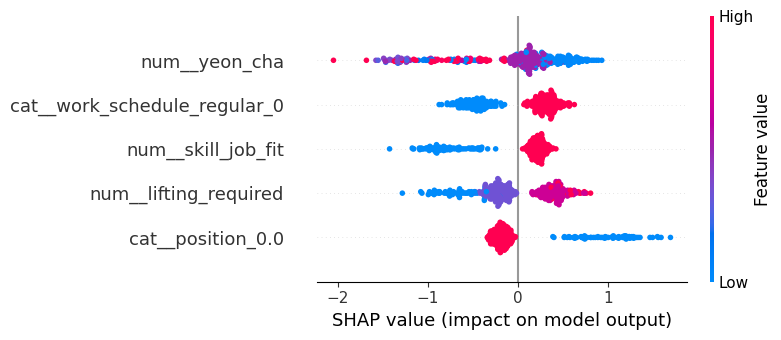

In [248]:
if hasattr(final_model, "named_steps"):
    prep = final_model.named_steps["prep"]
    clf  = final_model.named_steps["clf"]
    X_test_trans = prep.transform(X_test)
    try:
        feature_names = prep.get_feature_names_out()
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(X_test_trans.shape[1])])
    model_for_shap = clf
    X_for_shap = X_test_trans
else:  # CatBoost 단독 모델
    model_for_shap = final_model
    feature_names = np.array(X_test.columns)
    X_for_shap = X_test

# --- SHAP 계산 (트리 기반 전용 Explainer) ---
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer(X_for_shap)  # shap.Explanation

# --- 상위 5개 피처 선정 ---
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_order = np.argsort(mean_abs_shap)[::-1]
top_idx = feature_order[:5]
top_features = feature_names[top_idx].tolist()
print("상위 5개 변수:", top_features)

# --- 요약 플롯(Top-5만) ---
X_plot = X_for_shap[:, top_idx] if isinstance(X_for_shap, np.ndarray) else X_for_shap.iloc[:, top_idx]
shap.summary_plot(shap_values.values[:, top_idx], X_plot, feature_names=feature_names[top_idx])

/tmp/ipython-input-3241786212.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, top_idx], X_plot, feature_names=feature_names[top_idx])


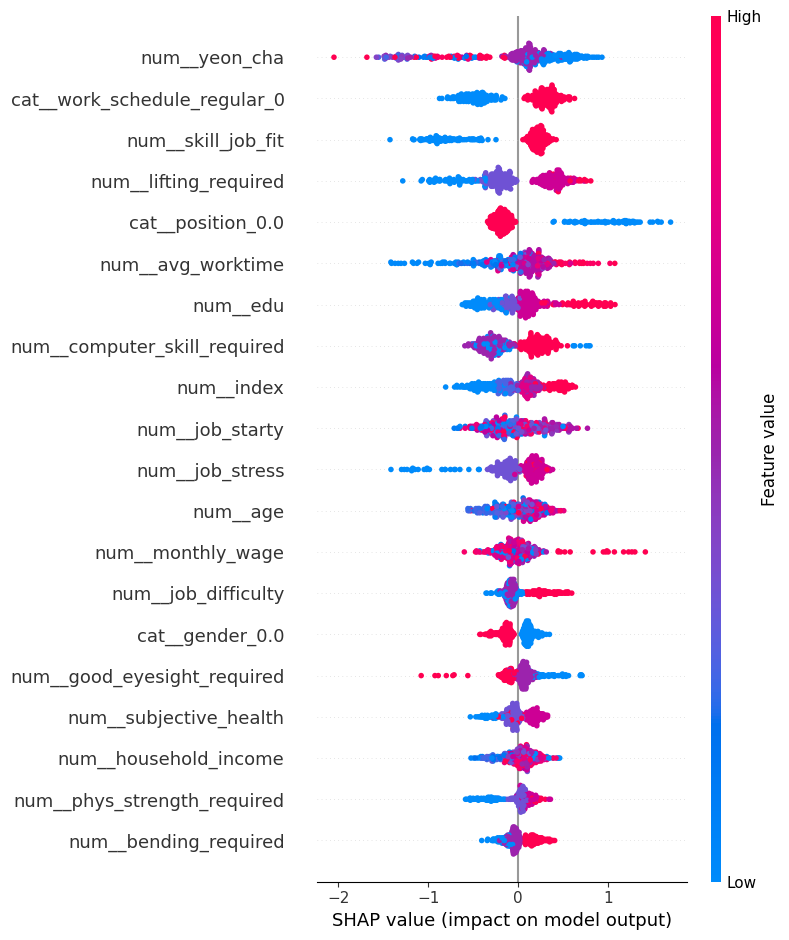

In [249]:
top_k = 0
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_order = np.argsort(mean_abs_shap)[::-1]
top_idx = feature_order[top_k:]
top_features = feature_names[top_idx].tolist()

# --- 요약 플롯(Top-k) ---
X_plot = X_for_shap[:, top_idx] if isinstance(X_for_shap, np.ndarray) else X_for_shap.iloc[:, top_idx]
shap.summary_plot(shap_values.values[:, top_idx], X_plot, feature_names=feature_names[top_idx])

/tmp/ipython-input-221441647.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


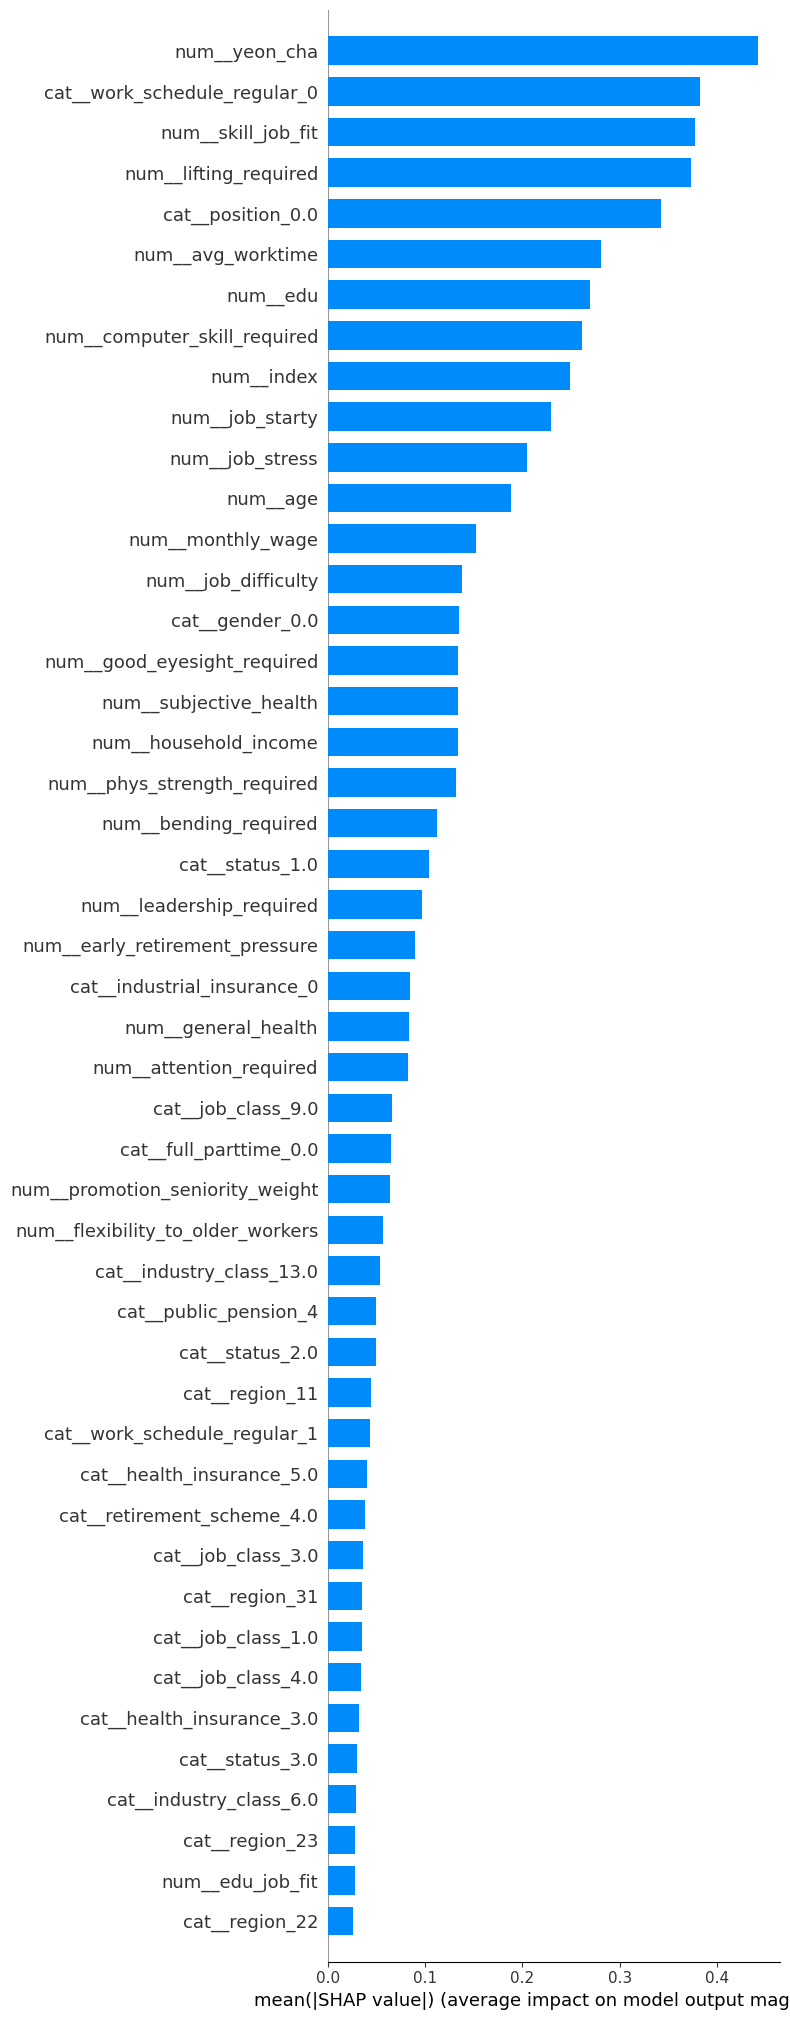

In [250]:
if hasattr(final_model, "named_steps"):  # LightGBM, XGBoost, RF 등 파이프라인
    prep = final_model.named_steps["prep"]
    clf  = final_model.named_steps["clf"]
    X_test_trans = prep.transform(X_test)  # OHE 포함 변환
    try:
        feature_names = prep.get_feature_names_out()
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(X_test_trans.shape[1])])
    model_for_shap = clf
    X_for_shap = X_test_trans
else:  # CatBoost 단독 모델
    model_for_shap = final_model
    feature_names = np.array(X_test.columns)
    X_for_shap = X_test  # 이미 sanitize_for_catboost 적용된 상태

# --- SHAP 계산 ---
explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer(X_for_shap)

# --- bar plot (max_display 조정 가능) ---
shap.summary_plot(
    shap_values,
    X_for_shap,
    feature_names=feature_names,
    plot_type="bar",
    max_display=47
)

In [251]:
def _get_model_inputs_and_names(final_model, X_test):

    if hasattr(final_model, "named_steps"):  # 파이프라인(LGBM/XGB/RF 등)
        prep = final_model.named_steps["prep"]
        clf  = final_model.named_steps["clf"]
        X_trans = prep.transform(X_test)
        # 희소 -> 밀집
        if sparse.issparse(X_trans):
            X_trans = X_trans.toarray()
        try:
            feature_names = prep.get_feature_names_out()
        except Exception:
            feature_names = np.array([f"f{i}" for i in range(X_trans.shape[1])])
        return X_trans, np.array(feature_names), clf
    else:  # CatBoost 단일 모델
        X_arr = X_test.to_numpy() if hasattr(X_test, "to_numpy") else np.asarray(X_test)
        feature_names = np.array(getattr(X_test, "columns", [f"f{i}" for i in range(X_arr.shape[1])]))
        return X_arr, feature_names, final_model

def shap_interaction_screen(final_model, X_test, low_importance_vars, cutoffs=(0.95, 0.93, 0.90, 0.87, 0.85, 0.82)):

    X_for_shap, feature_names, model_for_shap = _get_model_inputs_and_names(final_model, X_test)

    # TreeExplainer + 상호작용
    explainer = shap.TreeExplainer(model_for_shap)
    try:
        siv = explainer.shap_interaction_values(X_for_shap)  # shape: (n_samples, M, M)
    except Exception as e:
        raise RuntimeError(
            "이 모델에서는 shap_interaction_values를 계산할 수 없습니다. "
            "트리 기반 모델인지, SHAP 버전 호환성을 확인하세요."
        ) from e

    # 피처별 상호작용 강도 점수 (샘플/상대피처 절댓값 합)
    # shape (M,)
    interaction_sum = np.abs(siv).sum(axis=0).sum(axis=1)
    interaction_series = pd.Series(interaction_sum, index=feature_names)
    interaction_ranked = interaction_series.sort_values(ascending=False)

    results = {}
    n_feat = len(interaction_ranked)

    for cutoff in cutoffs:
        cutoff_rank = int(n_feat * float(cutoff))
        cutoff_rank = max(1, min(cutoff_rank, n_feat))  # 경계 보호
        high_interaction_vars = interaction_ranked.iloc[:cutoff_rank].index.tolist()

        # 보호군(high_interaction_vars)을 제외한 low_importance만 제거
        final_removal_vars = [v for v in low_importance_vars if v not in high_interaction_vars]

        print(f"\n🧹 제거 대상 변수 (interaction 보호 상위 {int(cutoff*100)}% 유지): {len(final_removal_vars)}개")
        print(final_removal_vars)
        results[cutoff] = final_removal_vars

    return results

# ===== 사용 예시 =====
cutoffs = [0.99, 0.97, 0.95]
_ = shap_interaction_screen(final_model, X_test, low_importance_vars, cutoffs)


🧹 제거 대상 변수 (interaction 보호 상위 99% 유지): 14개
['gender', 'industry_class', 'health_insurance', 'avg_worktime', 'public_pension', 'marital', 'early_retirement_pressure', 'flexibility_to_older_workers', 'subjective_health', 'full_parttime', 'leadership_required', 'industrial_insurance', 'edu_job_fit', 'employment_insurance']

🧹 제거 대상 변수 (interaction 보호 상위 97% 유지): 14개
['gender', 'industry_class', 'health_insurance', 'avg_worktime', 'public_pension', 'marital', 'early_retirement_pressure', 'flexibility_to_older_workers', 'subjective_health', 'full_parttime', 'leadership_required', 'industrial_insurance', 'edu_job_fit', 'employment_insurance']

🧹 제거 대상 변수 (interaction 보호 상위 95% 유지): 14개
['gender', 'industry_class', 'health_insurance', 'avg_worktime', 'public_pension', 'marital', 'early_retirement_pressure', 'flexibility_to_older_workers', 'subjective_health', 'full_parttime', 'leadership_required', 'industrial_insurance', 'edu_job_fit', 'employment_insurance']


# **8. 최종 csv 저장**

In [252]:
# --- 10) Drop specified columns and save ---

cols_to_drop = [
    'index',
    'retirement_scheme',
    'health_insurance',
    'edu_job_fit',
    'public_pension',
    'jobwave',
    'wage_satisfaction',
    'job_security',
    'work_env_satisfaction',
    'job_content_satisfaction',
    'overall_satisfaction'
]

# 해당 컬럼 삭제
df_final = df_final.drop(columns=cols_to_drop, errors='ignore')

In [253]:
print(df_final.isnull().sum())

job_stress                      0
skill_job_fit                   0
job_class                       0
position                        0
full_parttime                   0
job_starty                      0
status                          0
industry_class                  0
monthly_wage                    0
avg_worktime                    0
employment_insurance            0
industrial_insurance            0
phys_strength_required          0
lifting_required                0
bending_required                0
good_eyesight_required          0
attention_required              0
leadership_required             0
computer_skill_required         0
job_difficulty                  0
work_schedule_regular           0
promotion_seniority_weight      0
early_retirement_pressure       0
flexibility_to_older_workers    0
edu                             0
gender                          0
age                             0
marital                         0
region                          0
household_inco

In [254]:
df_final['region_orig'] = df_final['region']

In [255]:
# [1] industry_class
industry_mapping = {
    1: '1차 산업',
    2: '1차 산업',
    3: '생산 및 제조업',
    4: '생산 및 제조업',
    5: '생산 및 제조업',
    6: '건설업',
    7: '도매 및 소매업',
    8: '숙박 및 음식점업',
    9: '운수업',
    11: '금융 및 부동산업',
    12: '금융 및 부동산업',
    13: '사업서비스업',
    14: '공공행정업',
    20: '공공행정업',
    15: '교육서비스업',
    16: '보건 및 사회복지사업',
    10: '문화/기타 서비스업',
    17: '문화/기타 서비스업',
    18: '문화/기타 서비스업',
    19: '문화/기타 서비스업'
}
df_final['industry_class'] = df_final['industry_class'].map(industry_mapping)

# [2] position
position_mapping = {
    0: '직책 없음',
    1: '평직원',
    8: '임원',
    2: '관리자급',
    3: '관리자급',
    4: '관리자급',
    5: '관리자급',
    6: '관리자급',
    7: '관리자급'
}
df_final['position'] = df_final['position'].map(position_mapping)

# [4] marital
marital_mapping = {
    1: '미혼/이혼/별거/사별',
    2: '기혼',
    3: '기혼',
    4: '기혼',
    5: '기혼'
}
df_final['marital'] = df_final['marital'].map(marital_mapping)

# region
region_mapping = {
    11: '서울',
    23: '인천',
    31: '경기',
    21: '부산',
    22: '대구',
    24: '광주',
    25: '대전',
    26: '울산',
    27: '세종',
    32: '강원',
    33: '충북',
    34: '충남',
    35: '전북',
    36: '전남',
    37: '경북',
    38: '경남'
}
df_final['region'] = df_final['region'].map(region_mapping)

In [256]:
unmapped_rows = df_final[df_final['region'].isna()][['region_orig', 'region']]

print(unmapped_rows)

Empty DataFrame
Columns: [region_orig, region]
Index: []


In [257]:
df_final = df_final.drop(columns = ['region_orig'])

In [258]:
df_final.columns

Index(['job_stress', 'skill_job_fit', 'job_class', 'position', 'full_parttime',
       'job_starty', 'status', 'industry_class', 'monthly_wage',
       'avg_worktime', 'employment_insurance', 'industrial_insurance',
       'phys_strength_required', 'lifting_required', 'bending_required',
       'good_eyesight_required', 'attention_required', 'leadership_required',
       'computer_skill_required', 'job_difficulty', 'work_schedule_regular',
       'promotion_seniority_weight', 'early_retirement_pressure',
       'flexibility_to_older_workers', 'edu', 'gender', 'age', 'marital',
       'region', 'household_income', 'subjective_health', 'general_health'],
      dtype='object')

In [259]:
df_final.columns = [
    '직무스트레스', '직무적합도', '직종', '직위', '근무형태',
    '입사연도', '고용상태', '산업분류', '월임금',
    '평균근무시간', '고용보험가입', '산재보험가입',
    '신체강도요구', '물건들기요구', '허리굽힘요구',
    '시력요구', '집중력요구', '리더십요구',
    '컴퓨터기술요구', '직무난이도', '근무일정규칙성',
    '승진연공서열중시', '조기퇴직압박',
    '고령친화성', '학력', '성별', '나이', '결혼여부',
    '지역', '가구소득', '주관적건강', '전반적건강'
]

df_final.head()

,직무스트레스,직무적합도,직종,직위,근무형태,입사연도,고용상태,산업분류,월임금,평균근무시간,...,조기퇴직압박,고령친화성,학력,성별,나이,결혼여부,지역,가구소득,주관적건강,전반적건강
0,2,3,9.0,평직원,1.0,2014.0,3.0,금융 및 부동산업,4.510860,84.0,...,2,4,2,0.0,70.0,미혼/이혼/별거/사별,서울,7.340187,5,4
1,2,3,9.0,평직원,1.0,2013.0,3.0,사업서비스업,4.948760,50.0,...,4,4,3,0.0,57.0,미혼/이혼/별거/사별,서울,8.514590,3,3
2,3,3,9.0,관리자급,0.0,2013.0,1.0,사업서비스업,3.433987,10.0,...,3,3,2,1.0,74.0,미혼/이혼/별거/사별,서울,5.993961,3,3
3,3,3,9.0,평직원,1.0,2014.0,3.0,건설업,5.198497,40.0,...,4,4,3,0.0,60.0,미혼/이혼/별거/사별,서울,8.881975,4,4
4,2,3,9.0,평직원,1.0,2014.0,3.0,금융 및 부동산업,4.820282,44.0,...,4,4,3,1.0,60.0,미혼/이혼/별거/사별,서울,8.748464,4,3


In [260]:
df_final['입사연도'] = df_final['입사연도'].round().astype(int)

In [261]:
print(df_final.isnull().sum())

직무스트레스      0
직무적합도       0
직종          0
직위          0
근무형태        0
입사연도        0
고용상태        0
산업분류        0
월임금         0
평균근무시간      0
고용보험가입      0
산재보험가입      0
신체강도요구      0
물건들기요구      0
허리굽힘요구      0
시력요구        0
집중력요구       0
리더십요구       0
컴퓨터기술요구     0
직무난이도       0
근무일정규칙성     0
승진연공서열중시    0
조기퇴직압박      0
고령친화성       0
학력          0
성별          0
나이          0
결혼여부        0
지역          0
가구소득        0
주관적건강       0
전반적건강       0
dtype: int64


In [262]:
df_final.to_excel("rag.xlsx", index=False)
print("Saved to rag.xlsx")

Saved to rag.xlsx
